Using FBProphet to make predictions on daily users in Google Calendar

In [2]:
%matplotlib inline
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Reads csv and set time as index

In [4]:
df = pd.read_csv('Gcalen.csv')
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df


Plot the data for both predicted and actual

In [5]:
def plot(df,df0):
    df1 = df.copy()
    df2 = df0.copy()
    df1 = time_set(df1)
    df2 = time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

Time prediction function

In [6]:
def timeprediction123(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())

    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

Time prediction with MAPE graph

In [7]:
def timepredictionMAPE(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

Function to visualize the predicted values

In [8]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [9]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


Performance head for google.calendar:num_1day_active_users
  horizon            mse        rmse         mae      mape  coverage
0 11 days  113246.906820  336.521778  212.538958  0.199473  0.823715
1 12 days  113190.031203  336.437262  214.863478  0.195595  0.818972
2 13 days  109945.182965  331.579829  215.586241  0.189863  0.822609
3 14 days   90444.663091  300.740192  212.876960  0.169747  0.799209
4 15 days   68700.659014  262.108106  192.104494  0.137730  0.822925
Performance tail for google.calendar:num_1day_active_users
    horizon            mse        rmse         mae      mape  coverage
85  96 days  381363.585444  617.546424  460.385464  0.280485  0.539855
86  97 days  376429.170223  613.538239  460.201594  0.277518  0.534783
87  98 days  370358.139748  608.570571  458.531149  0.284069  0.555797
88  99 days  360965.912546  600.804388  443.795359  0.279317  0.586957
89 100 days  372631.442911  610.435454  445.891831  0.289560  0.600725


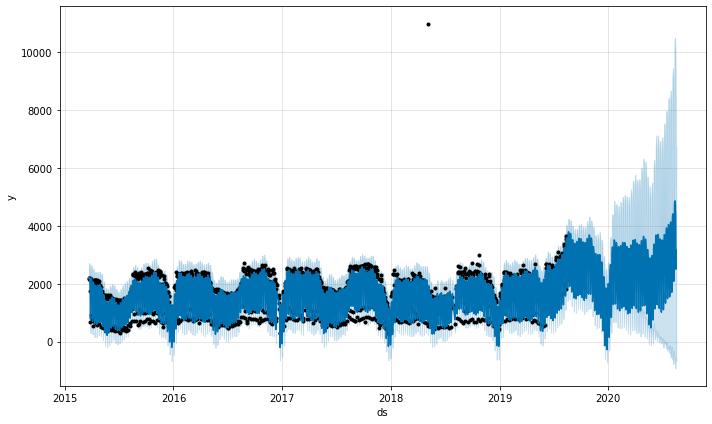

In [10]:
prediction = send_prediction(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


MAPE for google.calendar:num_1day_active_users predictions


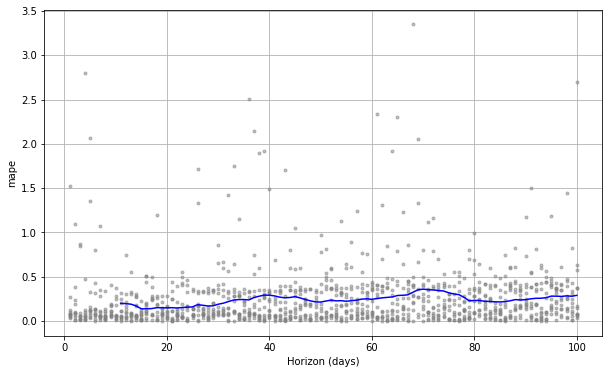

In [11]:
prediction1 = send_predictionMAPE(df)

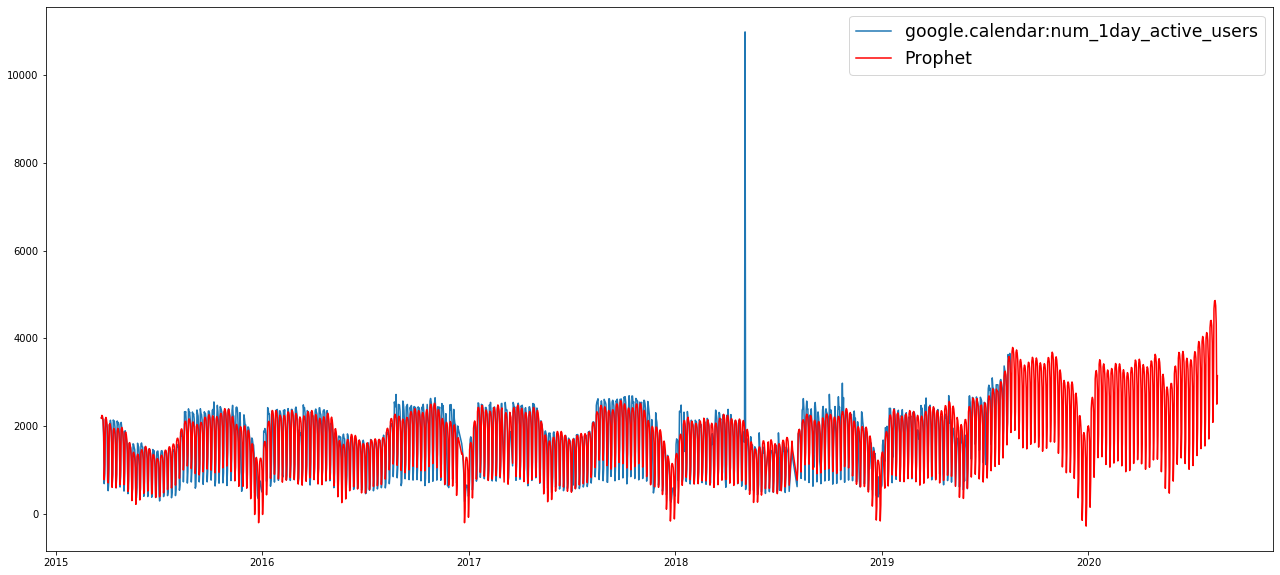

In [12]:
plot(df,prediction)

In [16]:
prediction.to_csv("PredictionCSV.csv", encoding='utf-8', index=True)
